In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [5]:
path = '/content/lfw'

In [6]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


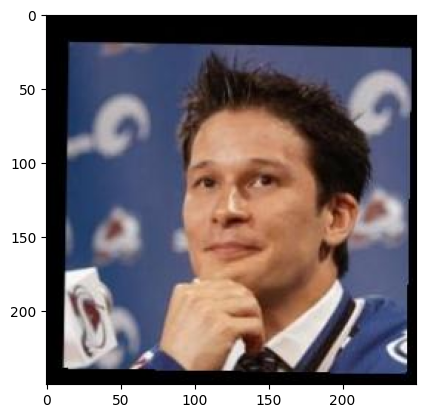

In [8]:

for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [9]:
#Step 2

# Extract a single image from the DataLoader
for images, _ in dataloader:
    sample_image = images[27]
    break

# Print the dimensions of the sample image
print("Dimensions of the sample image:", sample_image.shape)

# Dimensions
print("\nExplanation of each dimension:")
print("1st Dimension (Channels):", sample_image.shape[0], "- Number of color channels (3 for RGB)")
print("2nd Dimension (Height):", sample_image.shape[1], "- Height of the image in pixels")
print("3rd Dimension (Width):", sample_image.shape[2], "- Width of the image in pixels")


Dimensions of the sample image: torch.Size([3, 250, 250])

Explanation of each dimension:
1st Dimension (Channels): 3 - Number of color channels (3 for RGB)
2nd Dimension (Height): 250 - Height of the image in pixels
3rd Dimension (Width): 250 - Width of the image in pixels


**Step 2 Answer**

-The 1st Dimension shows the number 3 - Number of color channels (3 for RGB)

-The 2nd Dimension (Height): 250 is the Height of the image in pixels

-The 3rd Dimension (Width): 250 is the  Width of the image in pixels

# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)


    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)
        x = self.dec_bn3(self.dec_conv3(x))
        x = torch.sigmoid(x)  # Normalize the output
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [11]:
model = AE()

In [12]:

# Input tensor (batch size, channels, height, width)
sample_input = torch.randn(1, 3, 250, 250)

# Check if CUDA is available and move the model and input to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
    sample_input = sample_input.cuda()

# Pass the dummy image through the model
with torch.no_grad():
    encoded_output = model.encoder(sample_input)
    decoded_output = model.decoder(encoded_output)

# Print the shapes of the outputs
print("Shape of encoded output:", encoded_output.shape)
print("Shape of decoded output:", decoded_output.shape)

Shape of encoded output: torch.Size([1, 128, 31, 31])
Shape of decoded output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [13]:
#Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 299721


In [14]:
import torch.optim as optim

optim = optim.Adam(model.parameters(), lr=0.001)


In [15]:
loss_function = nn.MSELoss()

**Step 5 - Answers**

**Total Parameters:** This gives an idea of the model's complexity and capacity.

**Loss Function:** I have chosed the MSE loss as it is ideal for image reconstruction tasks, where we want to minimize the pixel-wise difference between the original and reconstructed images.

In direct comparison, Mean Squared Error (MSE) loss, used for its emphasis on pixel-wise accuracy, differs significantly from other loss functions in several aspects. Cross-Entropy Loss, ideal for classification tasks due to its effectiveness with probabilistic outputs, is less suitable for the pixel-level reconstruction needs of an autoencoder. Mean Absolute Error (MAE), though more robust to outliers than MSE, doesn't accentuate large errors as much, making it less sensitive but potentially less accurate for pixel-perfect image reconstruction. Huber Loss offers a middle ground, blending the properties of MSE and MAE, and is less sensitive to outliers than MSE; however, it introduces an additional hyperparameter that requires tuning. Binary Cross-Entropy Loss, a specialized form for binary classification tasks, is not applicable for continuous output values as in image reconstruction, highlighting MSE's appropriateness for autoencoders in image tasks. Each loss function has distinct characteristics, making MSE a preferred choice for tasks where precise, pixel-level reconstruction is crucial.

**Optimizer:** Adam is a good default choice for many deep learning tasks due to its adaptive learning rate capabilities and general robustness.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [19]:
# Assuming model, loss_function, optim, and dataloader are already defined
num_epochs = 10  # Define the number of epochs

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        # Check sizes
        #print(f"Input size: {inputs.size()}, Output size: {outputs.size()}")


        # Transfer to GPU if available
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1, Loss: 0.0009
Epoch 2, Loss: 0.0006
Epoch 3, Loss: 0.0006
Epoch 4, Loss: 0.0005
Epoch 5, Loss: 0.0005
Epoch 6, Loss: 0.0005
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0004


**Troubleshooting:**

As I monitor the training progress of my machine learning model, I sometimes encounter situations where the loss metric doesn't seem to be decreasing as expected. When faced with this challenge, I consider the following steps to diagnose and address the issue:

1. Learning Rate Adjustment:

I first examine the learning rate I've chosen for my optimizer. If the learning rate is too high, the model might take overly large steps during gradient descent, potentially overshooting the minima. Conversely, if the learning rate is too low, the training process may progress very slowly.
To address this, I experiment with different learning rates to find the right balance. This iterative process of learning rate tuning can often improve the model's convergence.
2. Model Architecture Review:

I take a closer look at the architecture of my neural network to ensure it's well-suited for the specific task I'm working on. It's important to consider factors like the number of layers, the type of activation functions, and the complexity of the model.
Sometimes, I may need to make architectural changes, such as adding more layers, adjusting the layer sizes, or changing activation functions, to enhance the model's ability to learn from the data effectively.
3. Data Preprocessing:

Proper data preprocessing is crucial for model training. I double-check that my data preprocessing steps, including data cleaning, feature scaling, and normalization, are correctly implemented.
Ensuring that the data is in a suitable format and range can significantly impact training success.
4. Overfitting Check:

Overfitting occurs when the model learns to perform exceptionally well on the training data but struggles to generalize to new, unseen data. To detect overfitting, I monitor the model's performance on a separate validation dataset.
If overfitting is suspected, I consider implementing regularization techniques, such as dropout or L1/L2 regularization, to prevent the model from fitting noise in the training data.
5. Batch Size Adjustment:

The choice of batch size can influence the stability of training. I experiment with different batch sizes to see if it has an impact on the convergence of the model.
Smaller batch sizes may introduce more noise into the gradient updates but can lead to better generalization, while larger batch sizes can provide more stable updates but may lead to slower convergence.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

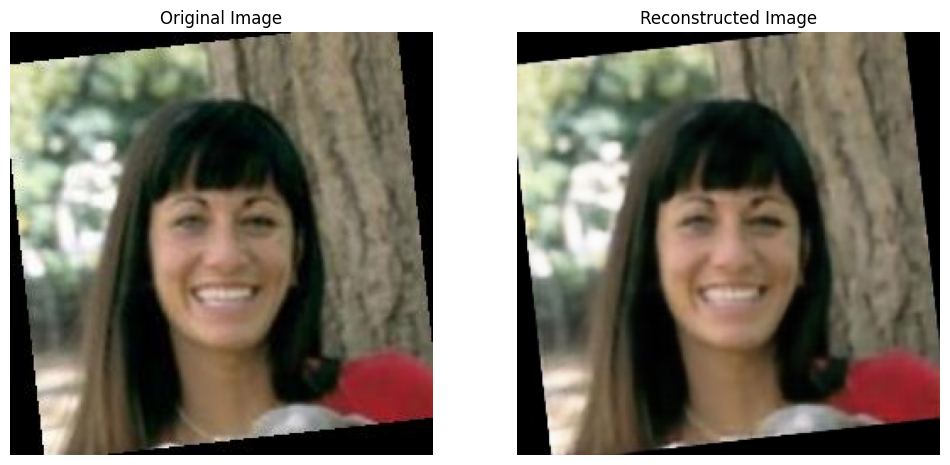

In [20]:

# Assuming model and dataloader are already defined
model.eval()

# Function to convert a tensor to an image
def tensor_to_image(tensor):
    # Convert the tensor format to image format [Height x Width x Channels]
    return tensor.permute(1, 2, 0).cpu().numpy()

# Get a single batch of images from the dataloader
images, _ = next(iter(dataloader))
original_img = images[0].unsqueeze(0)  # Take the first image from the batch

# Check if CUDA is available and move the image to GPU if it is
if torch.cuda.is_available():
    original_img = original_img.cuda()

# Pass the image through the model
with torch.no_grad():
    reconstructed_img = model(original_img)

# Convert tensors to images for display
original_img_display = tensor_to_image(original_img[0])
reconstructed_img_display = tensor_to_image(reconstructed_img[0])

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_display)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

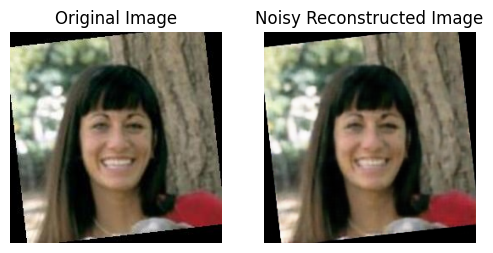

In [21]:
def plot_noisy_reconstruction(original, noisy_reconstruction):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original.permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Noisy Reconstructed Image')
    plt.imshow(noisy_reconstruction.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Step 8: Add noise to latent representation and decode
model.eval()
with torch.no_grad():
    # Assuming the encoded representation of the image is already obtained from Step 7
    encoded = model.encoder(original_img)

    # Add normally distributed noise
    noise = torch.randn(encoded.shape) * 0.1  # Adjust the noise level
    if torch.cuda.is_available():
        noise = noise.cuda()

    noisy_encoded = encoded + noise
    noisy_reconstructed_img = model.decoder(noisy_encoded)

    # Plot
    plot_noisy_reconstruction(original_img.cpu().squeeze(), noisy_reconstructed_img.cpu().squeeze())


**Observations:**

Effect of Noise: The noise added to the latent representation can cause various effects on the reconstructed image. For a well-trained autoencoder, a small amount of noise might not lead to significant changes, showcasing the model's robustness. However, larger amounts of noise can introduce artifacts, blurriness, or other distortions.

Robustness Evaluation: This step is useful for evaluating the robustness of your autoencoder to perturbations in the encoded space. It's especially relevant for applications in image denoising or for generative models where understanding the latent space's behavior is critical.

Noise Level: The magnitude of the noise (0.1 in the example) is a key factor. You can experiment with different levels to see how the autoencoder reacts to more or less perturbation.